In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, BatchNormalization, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load data

In [36]:
data = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/amazon/FshionProductReviews_V3.csv",
)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658184 entries, 0 to 658183
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     658184 non-null  int64 
 1   verified    658184 non-null  bool  
 2   reviewTime  658184 non-null  object
 3   reviewText  658183 non-null  object
 4   summary     658181 non-null  object
 5   length      658184 non-null  int64 
dtypes: bool(1), int64(2), object(3)
memory usage: 25.7+ MB


In [5]:
positive = data[data.overall > 3].head(40000)
negetive = data[data.overall < 4].head(40000)

In [6]:
trainset = pd.concat([positive, negetive])
trainset

,overall,verified,reviewTime,reviewText,summary,length
2,4,True,2014-05-31,These little plastic backs work great. No mor...,Works great!,28
5,4,True,2013-03-09,This brand has been around a long time and you...,BUXTON QUALITY!,26
10,5,True,2017-10-24,I love it it is just what I was looking for th...,Perfect just what I was looking for!,13
13,4,True,2017-07-02,Wonderful item. I have purchased several of th...,Made to last,27
14,5,True,2017-06-27,I just love it! I think this is my six or seve...,LOVE IT!,33
...,...,...,...,...,...,...
149478,3,True,2015-01-19,You get what you pay for ;).,Three Stars,7
149486,2,True,2015-01-17,Did not fit properly!,Two Stars,4
149488,3,True,2015-01-08,Looks just like picture a little bigger than w...,Three Stars,14
149490,2,True,2016-04-25,This product runs very short in the abdominal ...,Two Stars,9


In [37]:
testset = pd.concat([data[data.overall > 3].tail(40000), data[data.overall < 4].tail(40000)])

In [7]:
headline = trainset.reviewText.apply(
    lambda row: str(row)
)
labels = trainset.overall

In [8]:
labels

2         4
5         4
10        5
13        4
14        5
         ..
149478    3
149486    2
149488    3
149490    2
149492    2
Name: overall, Length: 80000, dtype: int64

In [9]:
labels.value_counts()

5    30857
3    16035
1    14070
2     9895
4     9143
Name: overall, dtype: int64

# Pre-process Labels

In [ ]:
labels[labels < 4] = 0
labels

In [ ]:
labels[labels > 3] = 1
labels

In [13]:
labels.value_counts()

1    40000
0    40000
Name: overall, dtype: int64

# Split

In [14]:
from sklearn.model_selection import train_test_split
train_headline, val_headline, train_labels, val_labels = train_test_split(
    headline, labels, test_size=0.3, random_state=33
)

In [15]:
# Encode labels
train_labels = tf.one_hot(
    train_labels,
    depth=2,
    on_value=None,
    off_value=None,
    axis=None,
    dtype=None,
    name=None
)

val_labels = tf.one_hot(
    val_labels,
    depth=2,
    on_value=None,
    off_value=None,
    axis=None,
    dtype=None,
    name=None
)

In [16]:
val_labels

<tf.Tensor: shape=(24000, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)>

In [17]:
data.length.quantile(0.75)

31.0

In [18]:
del data

# Pre-Processing

In [19]:
VOCAB_SIZE = 1000
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [20]:
# init Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=VOCAB_SIZE, oov_token="<OOV>"
)

# fit on data
tokenizer.fit_on_texts(train_headline)

# generate sequence
train_sequence = tokenizer.texts_to_sequences(train_headline)

# PAD Sequence
train_padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(
    train_sequence, maxlen=100, padding='post', truncating='post'
)
train_padded_sequence

array([[753,  17,  27, ...,   0,   0,   0],
       [185,  24,   6, ...,   0,   0,   0],
       [  3, 491,   2, ...,   0,   0,   0],
       ...,
       [549, 507,   0, ...,   0,   0,   0],
       [  5,  13, 306, ...,   0,   0,   0],
       [ 17,  20,   6, ...,   0,   0,   0]], dtype=int32)

In [21]:
val_sequence = tokenizer.texts_to_sequences(val_headline)
val_padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(
    val_sequence, maxlen=100, padding='post', truncating='post'
)
val_padded_sequence

array([[ 44, 301,  26, ...,   0,   0,   0],
       [  2, 112,  62, ...,   0,   0,   0],
       [ 80, 237,   7, ...,   0,   0,   0],
       ...,
       [ 61,  11, 277, ...,   0,   0,   0],
       [388,  30, 577, ...,   0,   0,   0],
       [  5,  13,  39, ...,   0,   0,   0]], dtype=int32)

In [22]:
tokenizer.num_words

1000

# Modeling LSTM

In [50]:
lstm_model = tf.keras.Sequential([
        Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=128
            ),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(128)),
        Dense(128, activation='relu'),
        Dropout(rate=0.5),
        Dense(128, activation='relu'),
        Dropout(rate=0.5),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')
])

In [51]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

In [52]:
with tf.device('/GPU:0'):
    # Compile
    lstm_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics= ['accuracy']
    )

    # Train
    lstm_model.fit(
        train_padded_sequence, train_labels,
        epochs=100,
        steps_per_epoch=500,
        validation_data=(val_padded_sequence, val_labels),
        validation_steps=50,
        callbacks=[es]
)

Epoch 1/100
500/500 [==============================] - 38s 55ms/step - loss: 0.3618 - accuracy: 0.8416 - val_loss: 0.2977 - val_accuracy: 0.8773
Epoch 2/100
500/500 [==============================] - 16s 32ms/step - loss: 0.2884 - accuracy: 0.8823 - val_loss: 0.2868 - val_accuracy: 0.8797
Epoch 3/100
500/500 [==============================] - 14s 27ms/step - loss: 0.2683 - accuracy: 0.8906 - val_loss: 0.2760 - val_accuracy: 0.8868
Epoch 4/100
500/500 [==============================] - 13s 26ms/step - loss: 0.2538 - accuracy: 0.8957 - val_loss: 0.2688 - val_accuracy: 0.8888
Epoch 5/100
500/500 [==============================] - 14s 28ms/step - loss: 0.2420 - accuracy: 0.9019 - val_loss: 0.2664 - val_accuracy: 0.8904
Epoch 6/100
500/500 [==============================] - 13s 27ms/step - loss: 0.2290 - accuracy: 0.9069 - val_loss: 0.2875 - val_accuracy: 0.8856
Epoch 7/100
500/500 [==============================] - 14s 27ms/step - loss: 0.2215 - accuracy: 0.9106 - val_loss: 0.2730 - val_ac

In [53]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         128000    
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 128)              

In [54]:
hist = pd.DataFrame(pd.DataFrame(lstm_model.history.history))
hist

,loss,accuracy,val_loss,val_accuracy
0,0.361797,0.841625,0.297670,0.877292
1,0.288429,0.882304,0.286796,0.879708
2,0.268304,0.890643,0.276012,0.886833
3,0.253772,0.895750,0.268792,0.888750
4,0.242045,0.901857,0.266361,0.890375
5,0.229012,0.906911,0.287504,0.885583
6,0.221542,0.910554,0.273025,0.886708
7,0.209323,0.916286,0.268040,0.889875


In [55]:
hist.describe().T

,count,mean,std,min,25%,50%,75%,max
loss,8.0,0.259278,0.048704,0.209323,0.227145,0.247908,0.273336,0.361797
accuracy,8.0,0.893241,0.023570,0.841625,0.888558,0.898804,0.907821,0.916286
val_loss,8.0,0.278025,0.011356,0.266361,0.268604,0.274518,0.286973,0.297670
val_accuracy,8.0,0.885641,0.004743,0.877292,0.884115,0.886771,0.889031,0.890375


In [56]:
hist.to_csv('/content/drive/MyDrive/Colab Notebooks/amazon/trainHistory.csv')

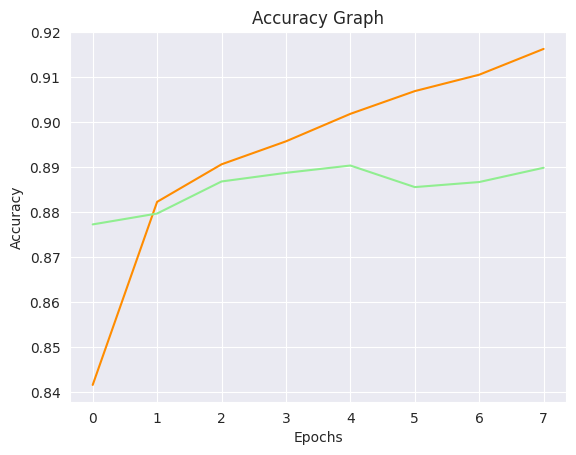

In [61]:
sns.set_style(style='darkgrid')
plt.plot(hist.index, hist.accuracy, color='darkorange')
plt.plot(hist.index, hist.val_accuracy, color='lightgreen')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Graph")
plt.show()

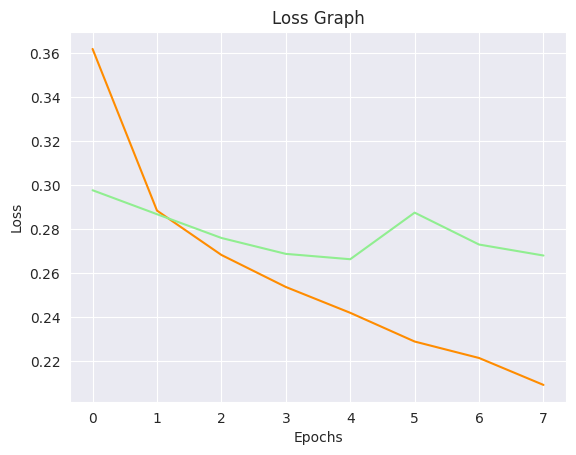

In [62]:
sns.set_style(style='darkgrid')
plt.plot(hist.index, hist.loss, color='darkorange')
plt.plot(hist.index, hist.val_loss, color='lightgreen')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.show()

In [80]:
lstm_model.save('/content/drive/MyDrive/Colab Notebooks/amazon/model/my_model.keras')